In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import numpy as np
import numpy.random as rnd
from sklearn.linear_model import LinearRegression, LassoCV

In [3]:
# (1)
n = 1000
p = 500
s1 = s2 = 10
X0 = rnd.normal(size=(n, p))

In [4]:
# (2)
U0 = rnd.normal(size=(p, p))
Sigma = U0*U0.T
U, V, D = np.linalg.svd(Sigma, full_matrices=True)
V_ = np.sqrt(V)
X = np.dot(X0, U) * np.dot(V_, D)
# do not forget to comment

In [5]:
# (3)
mu1 = 5
sig1 = np.sqrt(2)
b1 = rnd.normal(mu1, sig1, size=(s1,))

In [6]:
# (4)
mu2 = 3
sig2 = 1
b2 = rnd.normal(mu1, sig1, size=(s2,))

In [7]:
# (5)
# Создаю переменную, которую буду подгонять
_j = theano.shared(rnd.randn(n), name="j")

# Создаю переменные, которые будут входными параметрами функции
_X = T.matrix("X")
_b = T.vector("b")

# Это будет переменной, которая отправляется в сигмоид для вычисления пи
_inp = _j + T.dot(_X, _b)

# поэлементно считаем сигму, считаем пи
_pi, _ = theano.scan(lambda v: T.exp(v) / (1 + T.exp(v)), sequences=_inp)

# Чтобы подогнать j, надо задать функцию потерь
_cost = (T.sum(_pi)/n - 0.5)**2

# ...и узнать градиент
_gj = T.grad(_cost, _j)

# на каждом шаге будем обновлять j против градиента
_train = theano.function([_X, _b], [_cost], updates=[(_j, _j - 0.0001*_gj)])

pi = theano.function([_X, _b], [_pi])

In [8]:
theano.printing.pydotprint(_cost, outfile="pics/cost_func.png", var_with_name_simple=True)

The output file is available at pics/cost_func.png


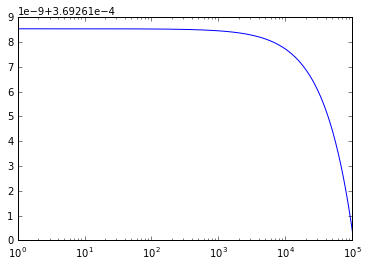

target sum(pi)/n =  0.480783825232


In [9]:
X2 = X[:, np.random.choice(X.shape[1], s2)]
steps = 100000
cost_path = []
for i in range(steps):
    cost_path.append(_train(X2, b2))
plt.plot(range(steps), cost_path)
plt.xscale("log")
plt.show()
print("target sum(pi)/n = ", np.sum(pi(X2, b2))/n)

In [10]:
# (6)
ber = np.vectorize(lambda p: rnd.binomial(1, p))
D = ber(pi(X2, b2)[0])
alpha = 5
Xf = np.vstack((D, X2.T)).T
ab = np.hstack((alpha, b2))
s = (ab.T @ Xf.T @ Xf @ ab)/n
sigma = np.sqrt(0.3*s)
print(sigma)

69.7890867606


In [11]:
# (7)
X1 = X[:, np.random.choice(X.shape[1], s1)]
Y = alpha*D + X1 @ b1 + rnd.normal(0, sigma)
print(Y.shape)

(1000,)


comment

In [12]:
# (b)
linreg = LinearRegression()
linreg.fit(np.matrix(D).T, Y)
print("coef from regression = ", linreg.coef_, "\n coef true = ", alpha)

coef from regression =  [-2.08466361] 
 coef true =  5


In [29]:
# (c)
Xl = np.vstack((D, X.T)).T
linreg_full = LinearRegression()
linreg.fit(Xl, Y)
print("coef from regression = ", linreg.coef_[0], "\n coef true = ", alpha)

coef from regression =  5.0 
 coef true =  5


In [40]:
class TwoStageLasso():
    def fit(self, X, target, y):
        first = LassoCV(cv=10)
        first.fit(X, target)
        nonzero_one = first.coef_ != 0
        second = LassoCV(cv=10)
        second.fit(X, y)
        nonzero_two = second.coef_ != 0
        self.nonzero = nonzero_one | nonzero_two
        Xl = np.vstack((target, X[:, self.nonzero].T)).T
        model = LinearRegression()        
        model.fit(Xl, y)
        self.coef_ = model.coef_

In [41]:
ts = TwoStageLasso()
ts.fit(X, D, Y)
print("coef from regression = ", ts.coef_[0], "\n coef true = ", alpha)

coef from regression =  4.94506157041 
 coef true =  5
